## **Init**

In [ ]:
import time
import sys
import os
import PIL
from PIL import ImageFont
import matplotlib.pylab as plt
import numpy as np
import json
import torch
from mpl_toolkits.mplot3d import Axes3D
from pose3d_utils.coords import ensure_cartesian
from VideoFrames import VideoFrames


from margipose.data.skeleton import CanonicalSkeletonDesc
from margipose.data_specs import ImageSpecs
from margipose.models import load_model
from margipose.utils import seed_all, init_algorithms, plot_skeleton_on_axes3d, plot_skeleton_on_axes, angleBetween


In [2]:
CPU = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
init_algorithms(deterministic=True)
torch.set_grad_enabled(False)
torch.no_grad()
seed_all(12345)

In [3]:
MODEL_PATH = "./pretrained/margipose-mpi3d.pth"
INPUT_FILE = "./Input/1.avi"

----

## **Load Model**

In [4]:
start = time.time()
model = load_model(MODEL_PATH).to(CPU).eval()
end = time.time()
print(end-start, "(s) to load Model")

Details {'type': 'margipose', 'version': '6.0.0', 'settings': {'n_stages': 4, 'axis_permutation': True, 'feature_extractor': 'inceptionv4', 'pixelwise_loss': 'jsd'}}
51.567015647888184 (s) to load Model


----
## **Load Video**

In [38]:
filename = os.path.basename(INPUT_FILE)
filename_noext = os.path.splitext(filename)[0]
(frameArray, fps) = VideoFrames.ExtractFrames(INPUT_FILE)
frameArray = np.asarray(frameArray, dtype=np.uint8)

480 x 640 Image size
83 Initial Frame Total
1.530738353729248 (s) to complete video to frame
17 FPS
83 Actaul Total Frames


In [37]:
# skel3DArray = np.zeros((480, 640, 3, frameArray.shape[3]), dtype=np.uint8)
# finalFrameArray = np.zeros((256, 256, 3, frameArray.shape[3]), dtype=np.uint8)
# strideAngles = np.zeros((frameArray.shape[3],3))

-----
## **Get Image Coordinates**

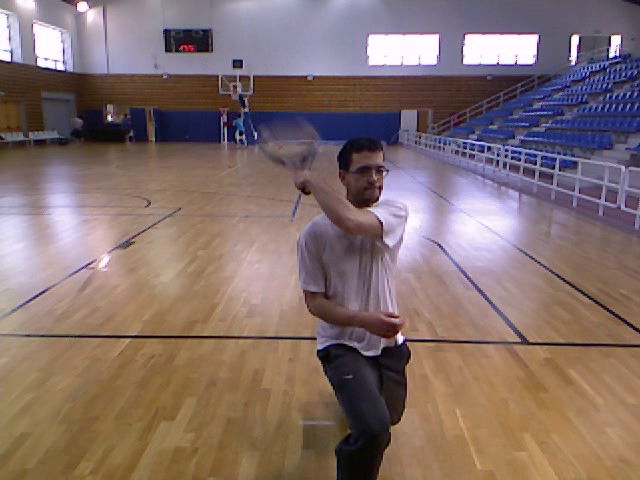

In [39]:
frame_number = 43
img = PIL.Image.fromarray(frameArray[:,:,:,frame_number][..., ::-1])
img

In [110]:
def process_image(image, input_specs):
    try:
        image: PIL.Image.Image = PIL.Image.open(image, 'r')
    except:
        pass
    if image.width != image.height:
        cropSize = min(image.width, image.height)
        image = image.crop((image.width/2 - cropSize/2, image.height/2 - cropSize/2,
                    image.width/2 + cropSize/2, image.height/2 + cropSize/2))
    if image.width < 256:
        image = image.resize((256, 256), PIL.Image.ANTIALIAS)
    image.thumbnail((input_specs.width, input_specs.height))
    return image

def get_coordinates(img):
    input_specs: ImageSpecs = model.data_specs.input_specs
    image = process_image(img, input_specs)
    input_image = input_specs.convert(image).to(CPU, torch.float32)
    output = model(input_image[None, ...])[0]
    norm_skel3d = ensure_cartesian(output.to(CPU, torch.float64), d=3)
    return norm_skel3d

skel3d = get_coordinates(img)
coords = skel3d.cpu().numpy()
# coords_img = np.rint((1+coords)*(255-0)/2)[:,:3].astype(int)

In [111]:
coords

array([[ 0.08971798, -0.73640108, -0.26522851],
       [ 0.08760244, -0.50474626, -0.14511225],
       [-0.0726176 , -0.43033129, -0.11380982],
       [-0.10110901, -0.20504463, -0.00140115],
       [-0.07037747, -0.0559706 , -0.09891601],
       [ 0.24092281, -0.41341755, -0.15445578],
       [ 0.25536206, -0.18410578, -0.08184005],
       [ 0.23505545,  0.01053197, -0.12258397],
       [-0.01791565,  0.02410735,  0.02095114],
       [-0.03660131,  0.30144322,  0.13441671],
       [-0.05861454,  0.56296158,  0.26866463],
       [ 0.13888009,  0.03296011, -0.02223743],
       [ 0.15747485,  0.30765668, -0.04071951],
       [ 0.13937335,  0.59063047,  0.11561106],
       [ 0.06022542,  0.02961252,  0.00122844],
       [ 0.07387701, -0.20372999, -0.0538268 ],
       [ 0.08904795, -0.62001282, -0.19800436]])

#### Plot Coordinates

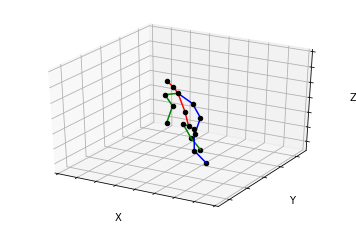

In [114]:
import matplotlib.pyplot as plt
# plot_coords = coords.T
# plot_coords = plot_coords*100
ax = plt.axes(projection='3d')
ax.set_xlabel('X', fontsize=10)
ax.set_ylabel('Y', fontsize=10)
ax.set_zlabel('Z', fontsize=10)

x=0
y=2
z=1
ax.set_xlim(-.8, .8)
ax.set_ylim(-.5, .5)
ax.set_zlim(-.8, .5)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_aspect('equal')
ax.invert_zaxis()
for coord in coords:
    ax.scatter3D(coord[x], coord[y], coord[z], c='0', cmap='Greens')
    
center_joints = [[0, 16], [16, 1], [1, 15], [15, 14]]
for joint in center_joints:
    ax.plot3D([coords[joint[0]][x], coords[joint[1]][x]], [coords[joint[0]][y], coords[joint[1]][y]], [coords[joint[0]][z], coords[joint[1]][z]],'red')
    
right_joints = [[1,2], [2,3], [3,4], [14,8], [8,9], [9,10]]
for joint in right_joints:
    ax.plot3D([coords[joint[0]][x], coords[joint[1]][x]], [coords[joint[0]][y], coords[joint[1]][y]], [coords[joint[0]][z], coords[joint[1]][z]],'green')
    
left_joints = [[1,5], [5,6], [6,7], [14,11], [11, 12], [12, 13]]
for joint in left_joints:
    ax.plot3D([coords[joint[0]][x], coords[joint[1]][x]], [coords[joint[0]][y], coords[joint[1]][y]], [coords[joint[0]][z], coords[joint[1]][z]],'blue')
    

In [115]:
def output_to_JSON(coords):
    # create JSON file with all the joints saved

    coords = coords*100
    joints_loc = {
        str("root"): {
            "pelvis" : {
                    "t": coords[14],
                    "r_hip" : {
                        "t": coords[8],
                        "r_knee" : {
                            "t": coords[9],
                            "r_ankle" : {
                                "t":coords[10],
                            },
                        },
                    },
                    "l_hip" : {
                        "t": coords[11],
                        "l_knee" : {
                            "t": coords[12],
                            "l_ankle" : {
                                "t": coords[13],
                            },
                        },
                    },
                    "spine" : {
                        "t": coords[15],
                        "neck": {
                            "t": coords[1],
                            "head" : {
                                "t": coords[16],
                                "head_top":{
                                    "t": coords[0],
                                },
                            },
                            "r_shoulder" : {
                                "t": coords[2],
                                "r_elbow" : {
                                    "t": coords[3],
                                    "r_wrist" : {
                                        "t": coords[4],
                                    },
                                },
                            },
                            "l_shoulder" : {
                                "t": coords[5],
                                "l_elbow" : {
                                    "t": coords[6],
                                    "l_wrist" : {
                                        "t": coords[7],
                                    },
                                },
                            },
                        },
                    },
                },
            },
        }

    return joints_loc

In [47]:
output_to_JSON(coords)

{'root': {'pelvis': {'t': array([17.43770689, 42.65760481,  0.57321703]),
   'r_hip': {'t': array([ 7.70762563, 42.94253588, -4.23700847]),
    'r_knee': {'t': array([ 24.01059419,  78.53198647, -21.73029333]),
     'r_ankle': {'t': array([12.32854128, 88.99878263,  4.36249301])}}},
   'l_hip': {'t': array([26.95851922, 42.30929911,  4.73899022]),
    'l_knee': {'t': array([22.8613168 , 78.98514867, 34.78446007]),
     'l_ankle': {'t': array([12.48964891, 84.82651711, 62.8015995 ])}}},
   'spine': {'t': array([14.29681629, 15.64893574, -9.29598734]),
    'neck': {'t': array([ 13.80115002, -13.69446367, -21.83516026]),
     'head': {'t': array([ 16.919595  , -28.22217345, -27.51866877]),
      'head_top': {'t': array([ 19.64331269, -43.52633655, -32.71607161])}},
     'r_shoulder': {'t': array([ -2.7523255 ,  -3.5196729 , -25.55919588]),
      'r_elbow': {'t': array([ -2.80659385,  26.29600763, -27.725178  ]),
       'r_wrist': {'t': array([ 18.9757213 ,  33.58124197, -30.6910038 ])}}},

------
## **Get Coordinates for Video**

In [73]:
skel3DArray = np.zeros((17, 3, frameArray.shape[3]), dtype=np.float)
for i in range(frameArray.shape[3]):
    print("Frame", i)
    img = PIL.Image.fromarray(frameArray[:,:,:,i][..., ::-1])
    coords = get_coordinates(img)
    coords = coords.cpu().numpy()
#     print(coords)
    skel3DArray[:, :, i] = coords

Frame 0
Frame 1
Frame 2
Frame 3
Frame 4
Frame 5
Frame 6
Frame 7
Frame 8
Frame 9
Frame 10
Frame 11
Frame 12
Frame 13
Frame 14
Frame 15
Frame 16
Frame 17
Frame 18
Frame 19
Frame 20
Frame 21
Frame 22
Frame 23
Frame 24
Frame 25
Frame 26
Frame 27
Frame 28
Frame 29
Frame 30
Frame 31
Frame 32
Frame 33
Frame 34
Frame 35
Frame 36
Frame 37
Frame 38
Frame 39
Frame 40
Frame 41
Frame 42
Frame 43
Frame 44
Frame 45
Frame 46
Frame 47
Frame 48
Frame 49
Frame 50
Frame 51
Frame 52
Frame 53
Frame 54
Frame 55
Frame 56
Frame 57
Frame 58
Frame 59
Frame 60
Frame 61
Frame 62
Frame 63
Frame 64
Frame 65
Frame 66
Frame 67
Frame 68
Frame 69
Frame 70
Frame 71
Frame 72
Frame 73
Frame 74
Frame 75
Frame 76
Frame 77
Frame 78
Frame 79
Frame 80
Frame 81
Frame 82


In [87]:
skel3DArray.shape

(17, 3, 83)

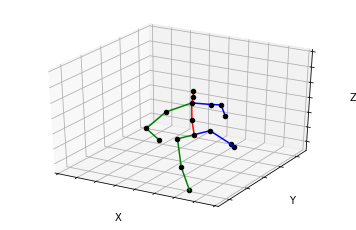

In [122]:
coords = skel3DArray[:, :, 30]
# coords = coords*100
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel('X', fontsize=10)
ax.set_ylabel('Y', fontsize=10)
ax.set_zlabel('Z', fontsize=10)

x=0
y=2
z=1
ax.set_xlim(-.8, .8)
ax.set_ylim(-.5, .5)
ax.set_zlim(-.8, .5)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_aspect('equal')
ax.invert_zaxis()
for coord in coords:
    ax.scatter3D(coord[x], coord[y], coord[z], c='0', cmap='Greens')

center_joints = [[0, 16], [16, 1], [1, 15], [15, 14]]
for joint in center_joints:
    ax.plot3D([coords[joint[0]][x], coords[joint[1]][x]], [coords[joint[0]][y], coords[joint[1]][y]], [coords[joint[0]][z], coords[joint[1]][z]],'red')

right_joints = [[1,2], [2,3], [3,4], [14,8], [8,9], [9,10]]
for joint in right_joints:
    ax.plot3D([coords[joint[0]][x], coords[joint[1]][x]], [coords[joint[0]][y], coords[joint[1]][y]], [coords[joint[0]][z], coords[joint[1]][z]],'green')

left_joints = [[1,5], [5,6], [6,7], [14,11], [11, 12], [12, 13]]
for joint in left_joints:
    ax.plot3D([coords[joint[0]][x], coords[joint[1]][x]], [coords[joint[0]][y], coords[joint[1]][y]], [coords[joint[0]][z], coords[joint[1]][z]],'blue')


In [48]:
image.thumbnail((input_specs.width, input_specs.height))

NameError: name 'image' is not defined

In [49]:
image

NameError: name 'image' is not defined

In [44]:
input_image = input_specs.convert(image).to(CPU, torch.float32)

In [53]:
output = model(input_image[None, ...])[0]

In [55]:
output.to(CPU, torch.float64)

tensor([[-0.1913, -0.6481, -0.1989],
        [-0.1134, -0.4280, -0.1378],
        [-0.1852, -0.3338, -0.2329],
        [ 0.0126, -0.1812, -0.3575],
        [ 0.1806, -0.1169, -0.3652],
        [-0.0124, -0.4384, -0.0462],
        [ 0.0654, -0.2546,  0.0666],
        [ 0.1901, -0.1802, -0.1253],
        [-0.1478,  0.0683, -0.0595],
        [-0.2283,  0.4125, -0.0763],
        [-0.2878,  0.7680, -0.0850],
        [ 0.0040,  0.0598,  0.0530],
        [ 0.0510,  0.4016,  0.0705],
        [ 0.0777,  0.7225,  0.1352],
        [-0.0722,  0.0650, -0.0012],
        [-0.0838, -0.1736, -0.0460],
        [-0.1530, -0.5401, -0.1736]], device='cuda:0', dtype=torch.float64)

In [57]:
temp = output.to(CPU, torch.float64)

In [61]:
norm_skel3d = ensure_cartesian(output.to(CPU, torch.float64), d=3)

In [62]:
norm_skel3d

tensor([[-0.1913, -0.6481, -0.1989],
        [-0.1134, -0.4280, -0.1378],
        [-0.1852, -0.3338, -0.2329],
        [ 0.0126, -0.1812, -0.3575],
        [ 0.1806, -0.1169, -0.3652],
        [-0.0124, -0.4384, -0.0462],
        [ 0.0654, -0.2546,  0.0666],
        [ 0.1901, -0.1802, -0.1253],
        [-0.1478,  0.0683, -0.0595],
        [-0.2283,  0.4125, -0.0763],
        [-0.2878,  0.7680, -0.0850],
        [ 0.0040,  0.0598,  0.0530],
        [ 0.0510,  0.4016,  0.0705],
        [ 0.0777,  0.7225,  0.1352],
        [-0.0722,  0.0650, -0.0012],
        [-0.0838, -0.1736, -0.0460],
        [-0.1530, -0.5401, -0.1736]], device='cuda:0', dtype=torch.float64)

In [63]:
coords = norm_skel3d.cpu().numpy()

In [50]:
coords

array([[ 0.19643313, -0.43526337, -0.32716072],
       [ 0.1380115 , -0.13694464, -0.2183516 ],
       [-0.02752325, -0.03519673, -0.25559196],
       [-0.02806594,  0.26296008, -0.27725178],
       [ 0.18975721,  0.33581242, -0.30691004],
       [ 0.29792312, -0.11372601, -0.1992256 ],
       [ 0.16566731, -0.06397698, -0.69943005],
       [-0.00977021, -0.20785987, -0.66842192],
       [ 0.07707626,  0.42942536, -0.04237008],
       [ 0.24010594,  0.78531986, -0.21730293],
       [ 0.12328541,  0.88998783,  0.04362493],
       [ 0.26958519,  0.42309299,  0.0473899 ],
       [ 0.22861317,  0.78985149,  0.3478446 ],
       [ 0.12489649,  0.84826517,  0.628016  ],
       [ 0.17437707,  0.42657605,  0.00573217],
       [ 0.14296816,  0.15648936, -0.09295987],
       [ 0.16919595, -0.28222173, -0.27518669]])

In [51]:
coords_raw = coords

In [52]:
coords_img = np.rint((1+coords)*(255-0)/2)[:,:3].astype(int)

In [53]:
img = input_specs.unconvert(input_image.to(CPU).cpu())

NameError: name 'input_specs' is not defined

In [54]:
fig = plt.figure(1)

<Figure size 432x288 with 0 Axes>

In [55]:
plt_3d: Axes3D = fig.add_subplot(1, 1, 1, projection='3d')

In [73]:
coords_img

array([[103,  45, 102],
       [113,  73, 110],
       [104,  85,  98],
       [129, 104,  82],
       [151, 113,  81],
       [126,  72, 122],
       [136,  95, 136],
       [152, 105, 112],
       [109, 136, 120],
       [ 98, 180, 118],
       [ 91, 225, 117],
       [128, 135, 134],
       [134, 179, 136],
       [137, 220, 145],
       [118, 136, 127],
       [117, 105, 122],
       [108,  59, 105]])

NameError: name 'norm_skel3d' is not defined

In [57]:
image = img
input_specs: ImageSpecs = model.data_specs.input_specs

try:
    image: PIL.Image.Image = PIL.Image.open(image, 'r')
except:
    pass
if image.width != image.height:
    cropSize = min(image.width, image.height)
    image = image.crop((image.width/2 - cropSize/2, image.height/2 - cropSize/2,
                image.width/2 + cropSize/2, image.height/2 + cropSize/2))
if image.width < 256:
    image = image.resize((256, 256), PIL.Image.ANTIALIAS)
image.thumbnail((input_specs.width, input_specs.height))
input_image = input_specs.convert(image).to(CPU, torch.float32)
output = model(input_image[None, ...])[0]
norm_skel3d = ensure_cartesian(output.to(CPU, torch.float64), d=3)

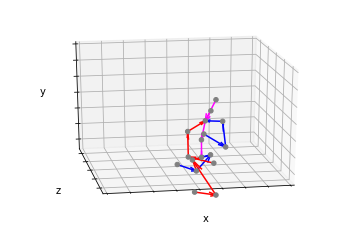

In [58]:
coords = norm_skel3d.cpu().numpy()
coords_raw = coords
coords_img = np.rint((1+coords)*(255-0)/2)[:,:3].astype(int)
fig = plt.figure(1)
plt_3d: Axes3D = fig.add_subplot(1, 1, 1, projection='3d')
plot_skeleton_on_axes3d(norm_skel3d, CanonicalSkeletonDesc, plt_3d, invert=True)

In [59]:
fig.canvas.draw()

In [60]:
fig_img = np.array(fig.canvas.renderer._renderer, np.uint8)[:,:,:3]

In [61]:
plt.close(fig)

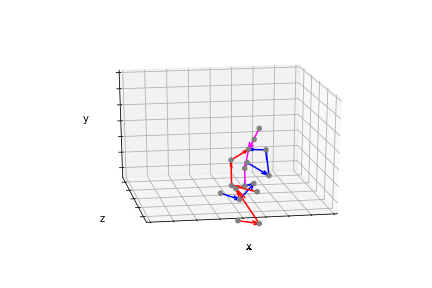

In [62]:
PIL.Image.fromarray(fig_img)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [1]:
import time
import sys
import os
import PIL
from PIL import ImageFont
import matplotlib.pylab as plt
import numpy as np
import json
import torch
from mpl_toolkits.mplot3d import Axes3D
from pose3d_utils.coords import ensure_cartesian
from VideoFrames import VideoFrames


from margipose.data.skeleton import CanonicalSkeletonDesc
from margipose.data_specs import ImageSpecs
from margipose.models import load_model
from margipose.utils import seed_all, init_algorithms, plot_skeleton_on_axes3d, plot_skeleton_on_axes, angleBetween


CPU = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
init_algorithms(deterministic=True)
torch.set_grad_enabled(False)
torch.no_grad()
seed_all(12345)

MODEL_PATH = "./pretrained/margipose-mpi3d.pth"
INPUT_FILE = "./ten.mp4"

start = time.time()
model = load_model(MODEL_PATH).to(CPU).eval()
end = time.time()
print(end-start, "(s) to load Model")

Details {'type': 'margipose', 'version': '6.0.0', 'settings': {'n_stages': 4, 'axis_permutation': True, 'feature_extractor': 'inceptionv4', 'pixelwise_loss': 'jsd'}}
76.72893333435059 (s) to load Model


In [27]:
input_specs: ImageSpecs = model.data_specs.input_specs
def process_image(image):
    try:
        image: PIL.Image.Image = PIL.Image.open(image, 'r')
    except:
        pass
    if image.width != image.height:
        cropSize = min(image.width, image.height)
        image = image.crop((image.width/2 - cropSize/2, image.height/2 - cropSize/2,
                    image.width/2 + cropSize/2, image.height/2 + cropSize/2))
    if image.width < 256:
        image = image.resize((256, 256), PIL.Image.ANTIALIAS)
    image.thumbnail((input_specs.width, input_specs.height))
    return image

def get_coordinates(img):
    image = process_image(img)
    input_image = input_specs.convert(image).to(CPU, torch.float32)
    output = model(input_image[None, ...])[0]
    norm_skel3d = ensure_cartesian(output.to(CPU, torch.float64), d=3)
    coords = norm_skel3d.cpu().numpy()
    return coords
    
def getPose(frameArray):
    skel3DArray = []
    for i in range(frameArray.shape[3]):
        print("Image: ", i)
        img = PIL.Image.fromarray(frameArray[:,:,:,i][..., ::-1])
        coords = get_coordinates(img)
        skel3DArray.append(coords)
    return np.array(skel3DArray)

In [28]:
filename = os.path.basename(INPUT_FILE)
filename_noext = os.path.splitext(filename)[0]
(frameArray, fps) = VideoFrames.ExtractFrames(INPUT_FILE)
frameArray = np.asarray(frameArray, dtype=np.uint8)
skel3DArray = getPose(frameArray)    
print(skel3DArray)

480 x 720 Image size
353 Initial Frame Total
5.588366746902466 (s) to complete video to frame
15 FPS
353 Actaul Total Frames
Image:  0
Image:  1
Image:  2
Image:  3
Image:  4
Image:  5
Image:  6
Image:  7
Image:  8
Image:  9
Image:  10
Image:  11
Image:  12
Image:  13
Image:  14
Image:  15
Image:  16
Image:  17
Image:  18
Image:  19
Image:  20
Image:  21
Image:  22
Image:  23
Image:  24
Image:  25
Image:  26
Image:  27
Image:  28
Image:  29
Image:  30
Image:  31
Image:  32
Image:  33
Image:  34
Image:  35
Image:  36
Image:  37
Image:  38
Image:  39
Image:  40
Image:  41
Image:  42
Image:  43
Image:  44
Image:  45
Image:  46
Image:  47
Image:  48
Image:  49
Image:  50
Image:  51
Image:  52
Image:  53
Image:  54
Image:  55
Image:  56
Image:  57
Image:  58
Image:  59
Image:  60
Image:  61
Image:  62
Image:  63
Image:  64
Image:  65
Image:  66
Image:  67
Image:  68
Image:  69
Image:  70
Image:  71
Image:  72
Image:  73
Image:  74
Image:  75
Image:  76
Image:  77
Image:  78
Image:  79
Image

In [29]:
skel3DArray

array([[[-2.06014365e-01, -5.24580300e-01,  1.58516951e-02],
        [-1.22756124e-01, -3.31395328e-01, -2.05238350e-04],
        [-1.07336760e-01, -3.14264804e-01,  6.43793344e-02],
        ...,
        [ 3.51269022e-02, -4.93895821e-02,  4.93441708e-03],
        [-5.22728488e-02, -1.87506407e-01, -2.65821237e-02],
        [-1.62898451e-01, -4.17285502e-01,  2.51714382e-02]],

       [[-2.04806045e-01, -5.24519861e-01,  1.65026970e-02],
        [-1.21945903e-01, -3.31718266e-01,  4.75476496e-04],
        [-1.04973383e-01, -3.15111905e-01,  6.55561537e-02],
        ...,
        [ 3.47428769e-02, -4.97146808e-02,  4.99365479e-03],
        [-5.20231351e-02, -1.87895536e-01, -2.63893344e-02],
        [-1.62053630e-01, -4.17521715e-01,  2.60726772e-02]],

       [[-1.42740667e-01, -5.02347887e-01, -1.69167854e-03],
        [-8.86232480e-02, -3.42366993e-01, -1.22239534e-02],
        [-4.16884944e-02, -3.31366152e-01,  3.75434011e-02],
        ...,
        [ 4.37855348e-02, -4.06787246e-02,

In [32]:
PIL.Image.fromarray(skel3DArray[0])

OSError: cannot write mode F as PNG

<PIL.Image.Image image mode=F size=3x17 at 0x7F04B4FE4208>

In [71]:
import matplotlib.pyplot as plt
# plot_coords = skel3DArray[352].T
# plot_coords = plot_coords*400
images = []
for i in range(skel3DArray.shape[0]):
    coords = skel3DArray[i]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection ='3d') 
    ax.set_xlabel('X', fontsize=10)
    ax.set_ylabel('Y', fontsize=10)
    ax.set_zlabel('Z', fontsize=10)

    x=0
    y=2
    z=1
    ax.set_xlim(-.8, .8)
    ax.set_ylim(-.5, .5)
    ax.set_zlim(-.8, .5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_aspect('equal')
    ax.invert_zaxis()
    for coord in coords:
        ax.scatter3D(coord[x], coord[y], coord[z], c='0', cmap='Greens')

    center_joints = [[0, 16], [16, 1], [1, 15], [15, 14]]
    for joint in center_joints:
        ax.plot3D([coords[joint[0]][x], coords[joint[1]][x]], [coords[joint[0]][y], coords[joint[1]][y]], [coords[joint[0]][z], coords[joint[1]][z]],'red')

    right_joints = [[1,2], [2,3], [3,4], [14,8], [8,9], [9,10]]
    for joint in right_joints:
        ax.plot3D([coords[joint[0]][x], coords[joint[1]][x]], [coords[joint[0]][y], coords[joint[1]][y]], [coords[joint[0]][z], coords[joint[1]][z]],'green')

    left_joints = [[1,5], [5,6], [6,7], [14,11], [11, 12], [12, 13]]
    for joint in left_joints:
        ax.plot3D([coords[joint[0]][x], coords[joint[1]][x]], [coords[joint[0]][y], coords[joint[1]][y]], [coords[joint[0]][z], coords[joint[1]][z]],'blue')
    fig.canvas.draw() 
    renderer = fig.canvas.renderer 
    ax.draw(renderer)  
    data = np.fromstring(ax.figure.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    data = data.reshape(ax.figure.canvas.get_width_height()[::-1] + (3,))
    images.append(PIL.Image.fromarray(data))
    plt.close()

/home/kunal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



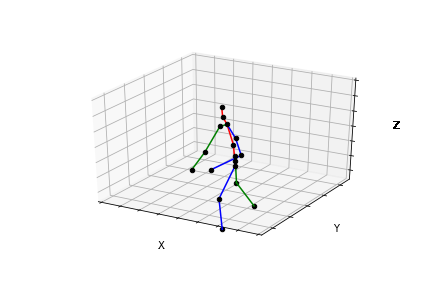

KeyboardInterrupt: 

In [89]:
from IPython.display import Image
from IPython.display import clear_output
import time
for i in range(len(images)):
    clear_output()
    display(images[i])
    time.sleep(0.01)

In [51]:
data = np.fromstring(ax.figure.canvas.tostring_rgb(), dtype=np.uint8, sep='')
data = data.reshape(ax.figure.canvas.get_width_height()[::-1] + (3,))

/home/kunal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



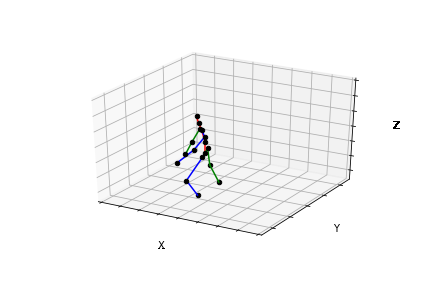

In [54]:
PIL.Image.fromarray(data)

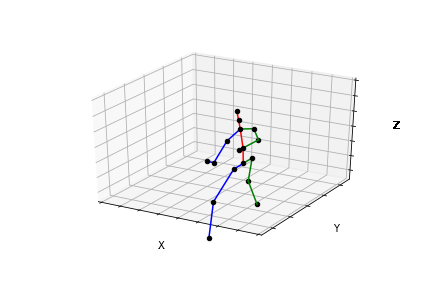

KeyboardInterrupt: 

In [96]:
from IPython.display import Image
from IPython.display import clear_output
import time
for i in range(len(images)):
    clear_output()
    display(images[i])
    time.sleep(0.2)

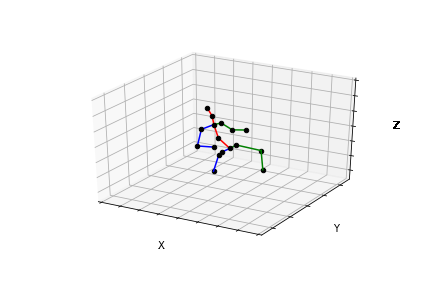

In [94]:
images[0]